In [1]:
%matplotlib inline
import sys
import os

import plotly.express as px

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch
from torch.utils.data import DataLoader

from tqdm import tqdm, trange
import nibabel as nib
from scipy import ndimage
import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);
from matplotlib import image, transforms

In [2]:
def resize_data_volume_by_scale(data, scale):
   """
   Resize the data based on the provided scale
   """
   scale_list = [scale,scale,scale]
   return ndimage.interpolation.zoom(data, scale_list, order=3)

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 10})

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

In [4]:
SYNTH_DATA_PATH = '../../seg_eval/'
BASE_LOG_PATH = 'assets/models/brain_atrophy/SVIExperiment'

os.chdir('/ritter/share/projects/larschen/3dscm_1gpu/3dscm')
from deepscm.experiments.brain_atrophy import synth # noqa: F401


In [5]:
from deepscm.datasets.atrophy_data import NvidiaDataset

synth_test = NvidiaDataset(train=False)
test_loader = DataLoader(synth_test, batch_size=4, shuffle=False, num_workers=16)

synth_train = NvidiaDataset(train=True)
test_loader = DataLoader(synth_train, batch_size=4, shuffle=False, num_workers=16)

In [ ]:
# recon = torch.load("assets/models/brain_atrophy/SVIExperiment/ConditionalVISEM/version_16/reconstruction.pt")

# for i in range(recon['x'].shape[0]):
#     x = np.clip(recon['x'][i,0,:,:,:].numpy(), 0, 255)/255
#     x = resize_data_volume_by_scale(x, 0.47**-1)
#     padding = [(12,160-148), (8,224-212), (0,160-136)]
#     x = np.pad(x, padding, mode='constant', constant_values=0)
#     x = nib.Nifti1Image(x, np.eye(4))
#     nib.save(x, f'../../seg_eval/recon_{i}.nii.gz')  
#     print(i/5)

In [7]:
os.getcwd()

'/ritter/share/projects/larschen/3dscm_1gpu/3dscm'

In [ ]:
vent_vols = np.zeros(500)
for i in range(500):
    seg = nib.load(f'../../segmentation/recon_{i}_synthseg.nii.gz').get_fdata()
    vent = np.isin(seg, [4, 5, 43, 44])
    vent_vols[i] = vent.sum()
    if i%100==0:
        print(i)


In [113]:
brain_vols = np.zeros(500)
for i in range(500):
    seg = nib.load(f'../../segmentation/recon_{i}_synthseg.nii.gz').get_fdata()
    brain_vols[i] = (np.isin(seg, [16,2,41])).sum()
    if i%10==0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


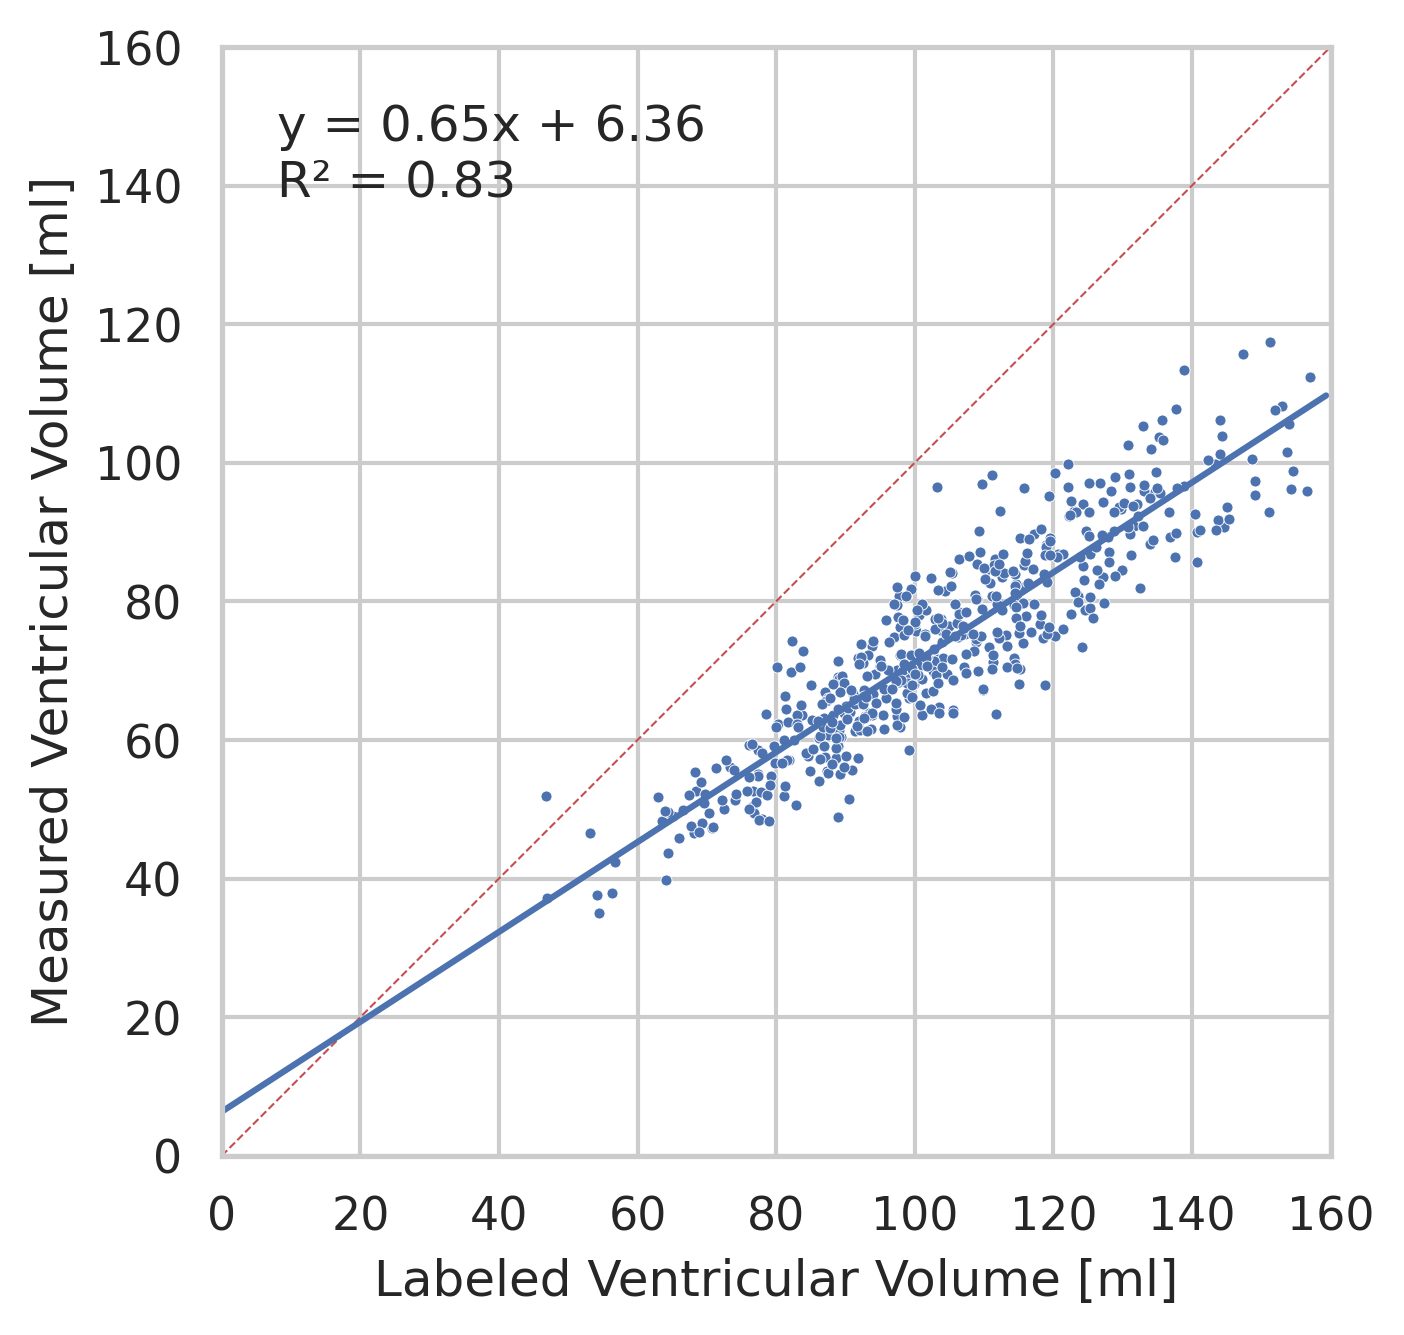

In [14]:
from scipy import stats

# Example data
x = np.array(synth_test.subjects['ventricle_vol'][:500])
y = vent_vols/1e3 # Linear relation with noise

fig, ax = plt.subplots()

xlims = [0,160]
ax.set_xlim(xlims)
ax.set_ylim(xlims)
ax.set_aspect('equal', adjustable='box')

# Create the linear regression plot
sns.set(style="whitegrid")
sns.scatterplot(x=x, y=y, ci=None, ax=ax, s=7)  # ci=None disables confidence interval shading
sns.lineplot(x=np.linspace(0, xlims[1],10), y=np.linspace(0, xlims[1],10), color='r', lw=0.5, linestyle="--", ax=ax)

# Calculate the regression equation and R² value
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

new_x = np.arange(xlims[0], xlims[1],(xlims[1]-xlims[0])/250.)
sns.lineplot(new_x, intercept + slope *  new_x, color='b', linestyle='-', ax=ax)

# Create the equation and R² string
equation_text = rf'v_{{seg}} = {slope:.2f}v_{{label}} + {intercept:.2f}'
r_squared_text = f'R² = {r_value**2:.2f}'

# Annotate the plot with the equation and R² value
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, r_squared_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Labeled Ventricular Volume [ml]')
plt.ylabel('Measured Ventricular Volume [ml]')

# Display the plot
plt.show()


/home/lars/anaconda3/envs/dscm/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


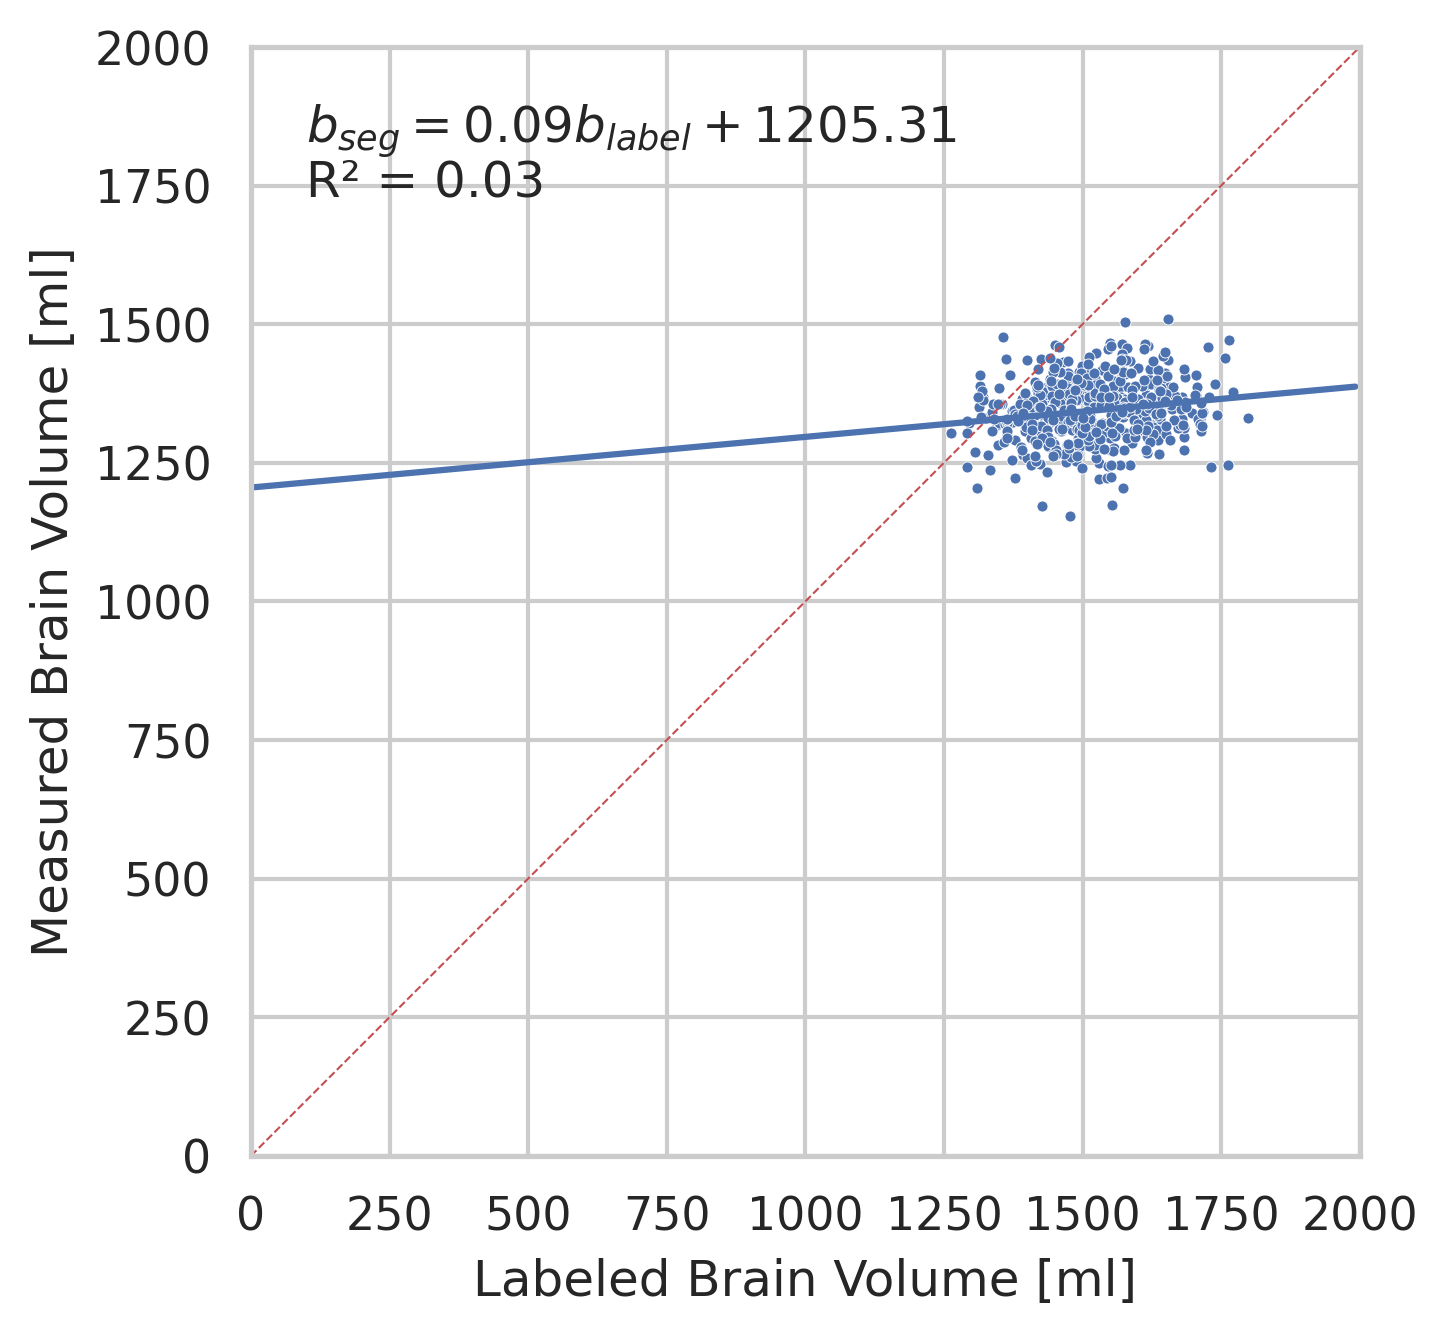

In [123]:
from scipy import stats

# Example data
x = np.array(synth_test.subjects['brain_vol'][:500])
y = brain_vols/1e3 # Linear relation with noise

fig, ax = plt.subplots()

xlims = [0,2000]
ax.set_xlim(xlims)
ax.set_ylim(xlims)
ax.set_aspect('equal', adjustable='box')

# Create the linear regression plot
sns.set(style="whitegrid")
sns.scatterplot(x=x, y=y, ci=None, ax=ax, s=7)  # ci=None disables confidence interval shading
sns.lineplot(x=np.linspace(0, xlims[1],10), y=np.linspace(0, xlims[1],10), color='r', lw=0.5, linestyle="--", ax=ax)

# Calculate the regression equation and R² value
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

new_x = np.arange(xlims[0], xlims[1],(xlims[1]-xlims[0])/250.)
sns.lineplot(new_x, intercept + slope *  new_x, color='b', linestyle='-', ax=ax)

# Create the equation and R² string
equation_text = rf'$b_{{seg}} = {slope:.2f}b_{{label}} + {intercept:.2f}$'
r_squared_text = f'R² = {r_value**2:.2f}'

# Annotate the plot with the equation and R² value
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, r_squared_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Labeled Brain Volume [ml]')
plt.ylabel('Measured Brain Volume [ml]')

# Display the plot
plt.show()


In [15]:
img = nib.load('../../seg_eval/recon_0.nii.gz').get_fdata()

In [86]:
og = nib.load('../../seg_eval/recon_2.nii.gz').get_fdata()

seg = nib.load('../../segmentation/recon_2_synthseg.nii.gz').get_fdata()
pos = nib.load('../../segmentation/recon_2_posteriors.nii.gz').get_fdata()



In [18]:
pos[pos<0.6] = 0
pos[pos>0.6] = 1


In [19]:
vent = pos[:,:,:,3] + pos[:,:,:,21]
wm = pos[:,:,:,1] + pos[:,:,:,19]

In [66]:
ndimage.rotate(brain[:,:,80].astype(np.int64), 90).min()

0

In [70]:
vent = np.isin(seg, [4, 5, 43, 44])
wm = np.isin(seg, [2, 7, 41, 46])
brain = np.isin(seg,[2,41,3,8,42,47])
brain[brain == True] = 1.0
brain[brain == False] = 0.0


fig, ax = plt.subplots(figsize=(1,1))
fig.tight_layout(pad=0)
#ax.imshow(ndimage.rotate(og[:,:,80],90), 'gray', alpha=1)
#ax.imshow(ndimage.rotate(vent[:,:,80],90), 'jet', alpha=ndimage.rotate(vent[:,:,80],90).astype(float), vmin=0)

ax.imshow(ndimage.rotate(brain[:,:,80],90), 'jet', alpha=ndimage.rotate(brain[:,:,80], 90)) #ndimage.rotate(brain_alpha[:,:,80],90), vmin=0)

ax.grid(False)
ax.axis('off')
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f447b1fff28> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 300x300 with 1 Axes>

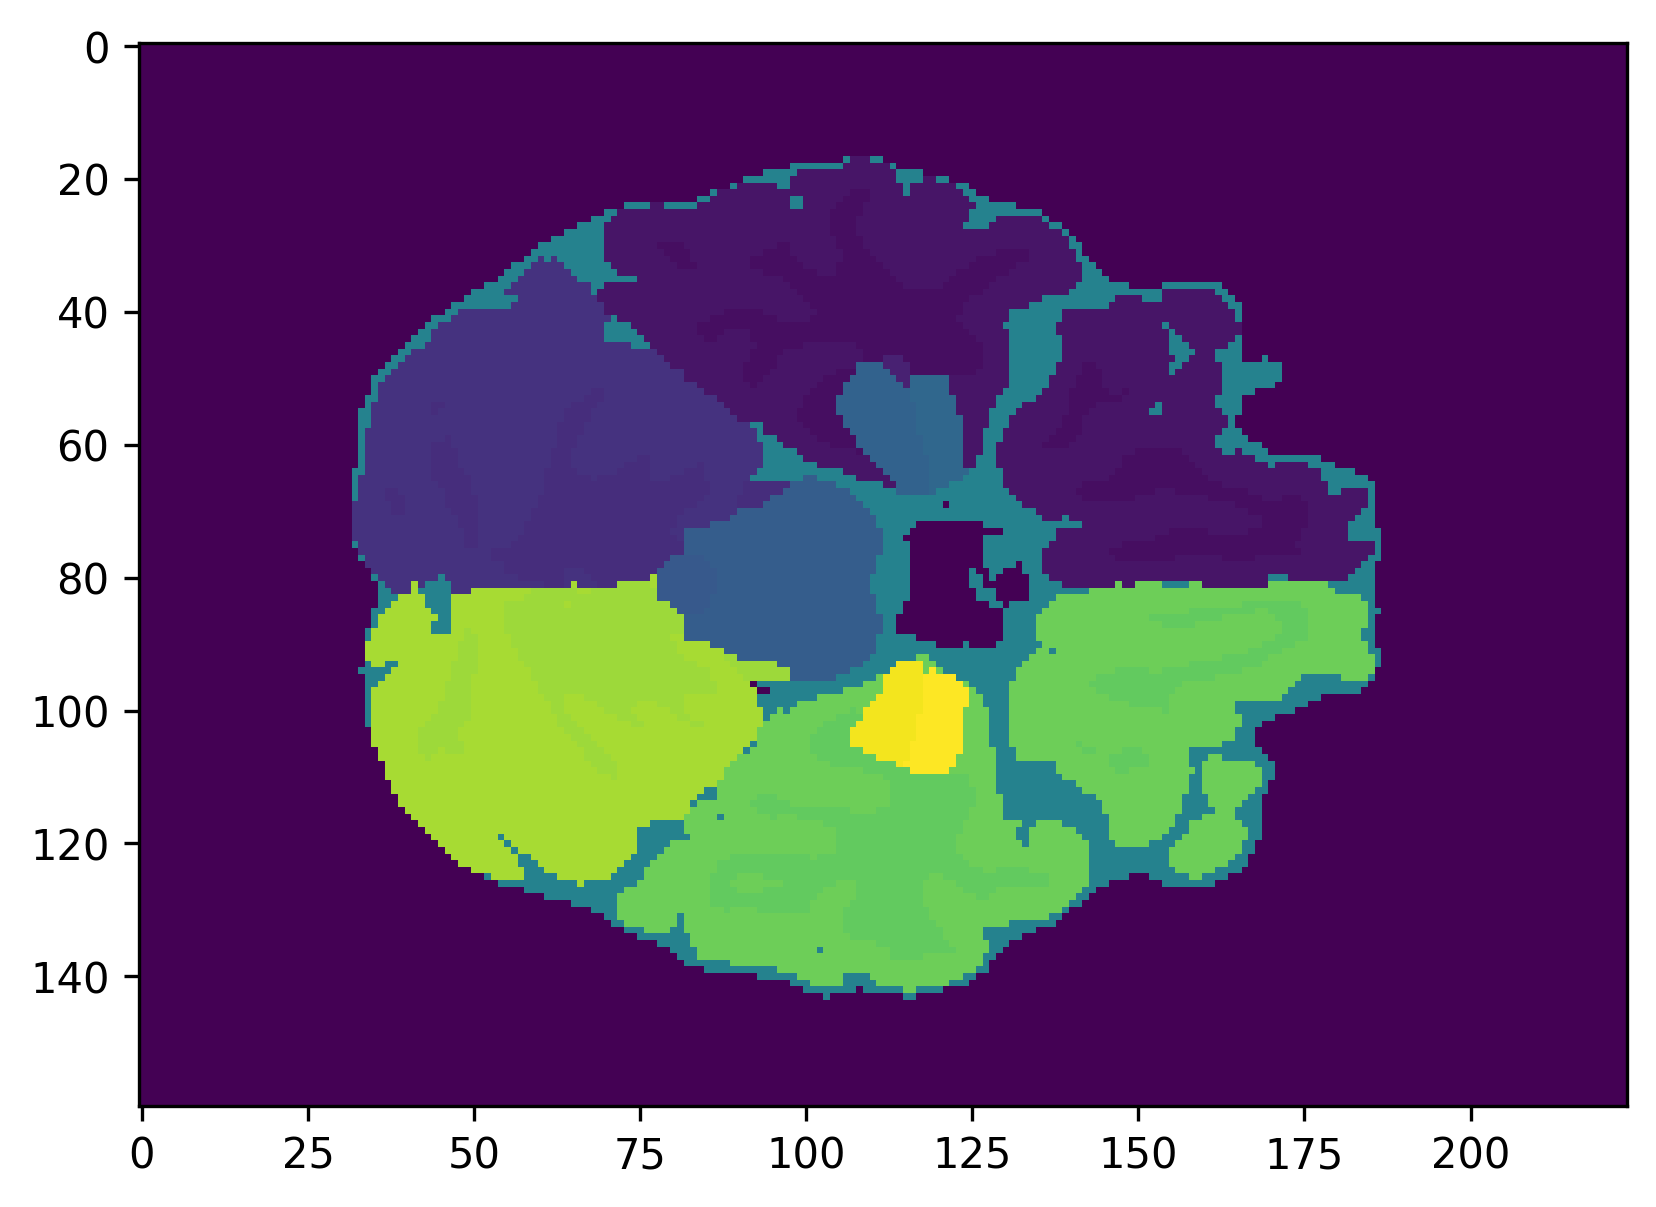

In [43]:
plt.imshow(seg[:,:,37])

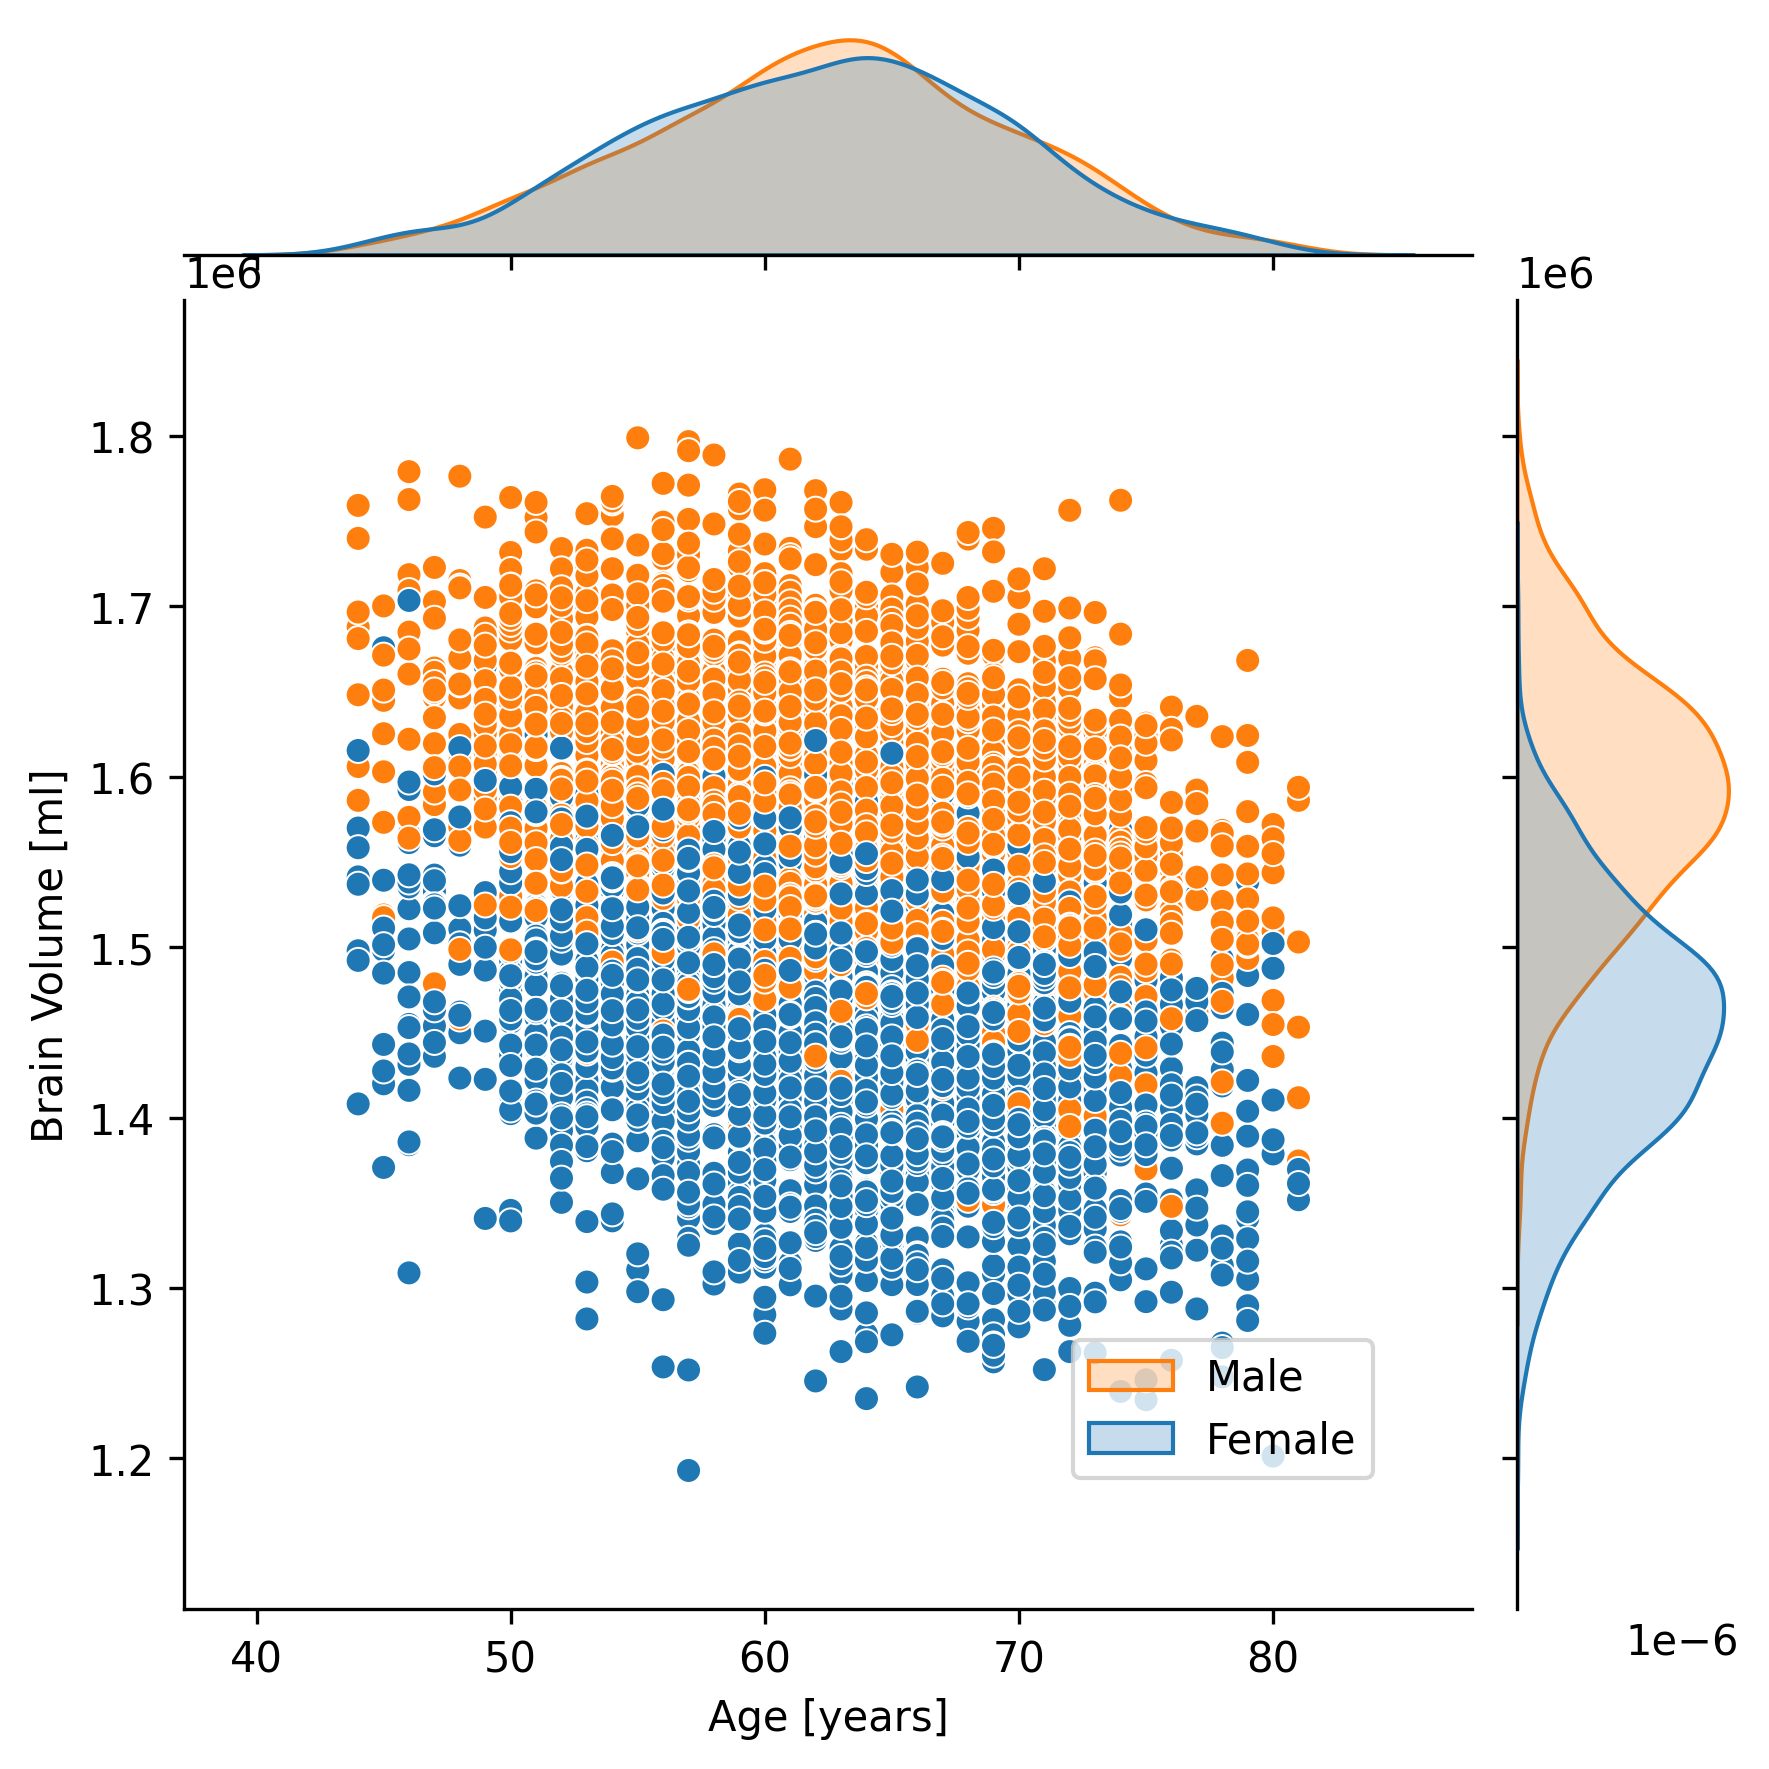

In [48]:
fig = sns.jointplot(data=df, x='age', y='brain_vol', hue='sex', legend=False)

fig.set_axis_labels('Age [years]', 'Brain Volume [ml]')
ax = plt.gca()
ax.legend(['Male', 'Female'], loc=[-2,0.1]) 


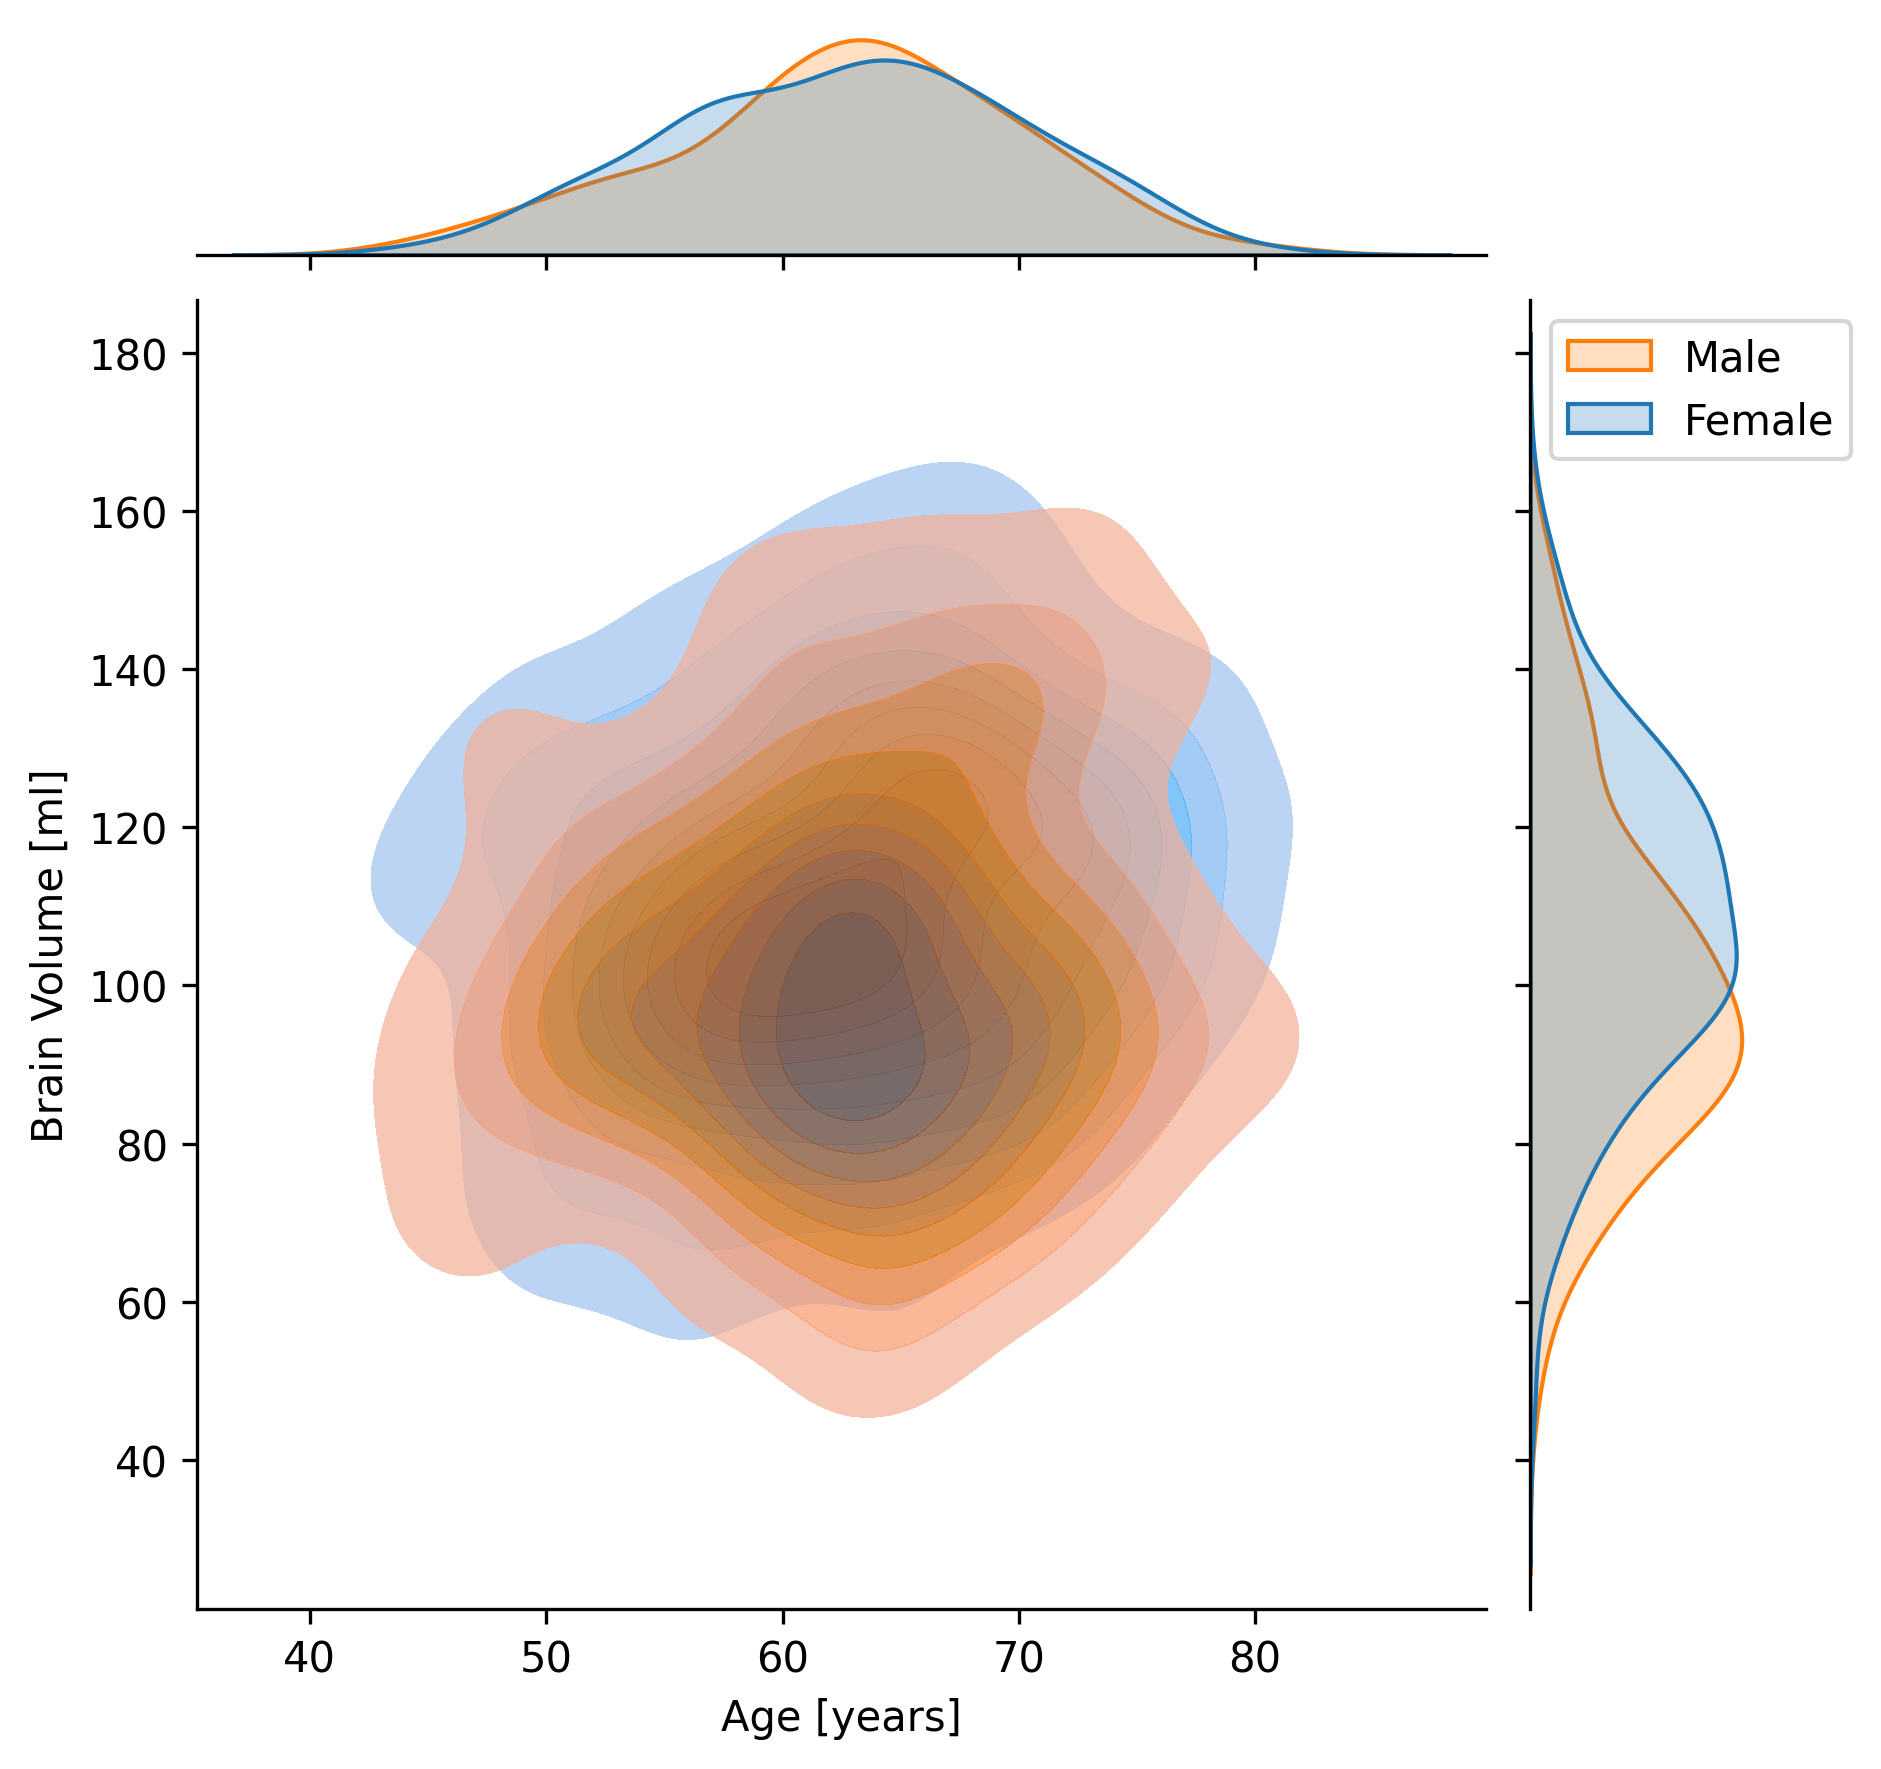

In [55]:
fig = sns.jointplot(data=synth_test.subjects, x='age', y='ventricle_vol', hue='sex', legend=False, kind='kde', fill=True, alpha=0.7)
fig.set_axis_labels('Age [years]', 'Brain Volume [ml]')
ax = plt.gca()
ax.legend(['Male', 'Female'], loc=2) 


In [ ]:
df[df.sex==0].describe()

,Unnamed: 0,subject,sex,age,ventricle_vol,brain_vol,lesion_num,lesion_vol,score
count,2487.000000,2487.000000,2487.0,2487.000000,2487.000000,2.487000e+03,2487.000000,2487.000000,2487.000000
mean,2505.295537,2505.295537,0.0,62.365903,108783.054282,1.449362e+06,3.262967,5570.839099,3.339509
std,1434.168731,1434.168731,0.0,7.230796,20959.191964,7.399051e+04,2.036475,3584.384925,1.634517
min,0.000000,0.000000,0.0,44.000000,46787.000000,1.192883e+06,0.000000,0.000000,0.521159
25%,1266.000000,1266.000000,0.0,57.000000,94285.500000,1.401002e+06,2.000000,2946.634164,2.147308
50%,2512.000000,2512.000000,0.0,63.000000,107982.000000,1.451791e+06,3.000000,5298.332023,2.969521
75%,3727.500000,3727.500000,0.0,67.000000,122447.500000,1.497524e+06,5.000000,7922.355142,4.211268
max,4999.000000,4999.000000,0.0,81.000000,169841.000000,1.703489e+06,10.000000,18245.355982,9.904685


In [ ]:
df[df.sex==1].describe()

,Unnamed: 0,subject,sex,age,ventricle_vol,brain_vol,lesion_num,lesion_vol,score
count,2513.000000,2513.000000,2513.0,2513.000000,2513.000000,2.513000e+03,2513.000000,2513.000000,2513.000000
mean,2493.764425,2493.764425,1.0,62.532829,98839.833665,1.588049e+06,3.204138,5486.312470,3.329863
std,1452.977934,1452.977934,0.0,7.196944,20862.519670,7.342731e+04,2.013517,3524.533843,1.650614
min,3.000000,3.000000,1.0,44.000000,32060.000000,1.324085e+06,0.000000,0.000000,0.554357
25%,1233.000000,1233.000000,1.0,58.000000,84176.000000,1.539874e+06,2.000000,2832.435413,2.106847
50%,2485.000000,2485.000000,1.0,63.000000,98150.000000,1.590317e+06,3.000000,5355.110528,3.009221
75%,3766.000000,3766.000000,1.0,67.000000,111736.000000,1.636950e+06,5.000000,7875.997990,4.187424
max,4996.000000,4996.000000,1.0,81.000000,167727.000000,1.798925e+06,10.000000,17945.519204,9.921885


In [ ]:
df[df.sex==1].score.median()

3.009220600128174

In [ ]:
df[df.sex==1].brain_vol.std()

73427.30544261265